In [1]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle
import os
import codecs
import unicodedata
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below
from sklearn import neighbors
from sklearn import cross_validation
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score 
import re
import string
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


/home/ebuka/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package wordnet to /home/ebuka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
pd_corpus_path = "/home/ebuka/Desktop/masterarbeit/dataframe"

In [7]:
import pandas as pd
#df= pd.read_csv('movies1.csv', sep = ',',skiprows=2)
#data= pd.read_csv('tempfile.csv', sep = ',',error_bad_lines=False)
data= pd.read_csv('movies.csv', sep = ',')
data.loc[data.review_score>3,'Sentiment']=1
data.loc[data.review_score<=3,'Sentiment']=0
data =data[['review_text','Sentiment']]
data = data[data.Sentiment.isnull() == False]
data['Sentiment'] = data['Sentiment'].map(int)
data = data[data['review_text'].isnull() == False]
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)
data.to_pickle(pd_corpus_path + '/movies.csv.pkl')
data.shape


(141589, 2)

In [11]:
data.head(20)

,review_text,Sentiment
0,Synopsis On the daily trek from Juarez Mexico...,0
1,THE VIRGIN OF JUAREZ is based on true events ...,0
2,The scenes in this film can be very disquieti...,1
3,THE VIRGIN OF JUAREZ (2006)<br />directed by ...,0
4,Informationally this SHOWTIME original is ess...,0
5,The murders in Juarez are real. This movie is...,0
6,Mexican men are macho rapists gangsters or in...,0
7,Over the past few years public television has...,1
8,I recvd this video (DVD version) as a Christm...,1
9,Wow! When I saw this show on PBS--that was it...,1


/home/ebuka/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


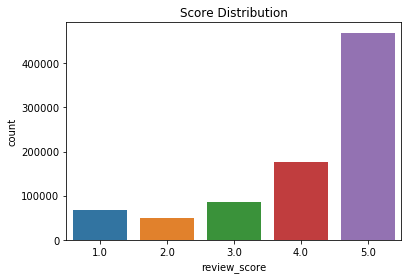

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.axes()
sns.countplot(data.review_score,ax=ax)
ax.set_title('Score Distribution')
plt.show()

In [4]:
print("Proportion of positive review:", len(data[data.Sentiment==1])/len(data))
print("Proportion of negative review:",len(data[data.Sentiment==0])/len(data))

Proportion of positive review: 0.7602989421196922
Proportion of negative review: 0.2397010578803078


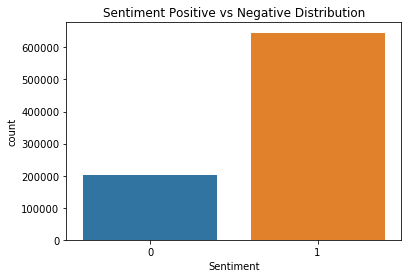

In [8]:
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [12]:
len(data)

849529

In [8]:
class preprocess(): 
    df = data
   
    def tokenize(self,tweet):
        try:     
            token = unicodedata.normalize("NFKD", tweet).encode("ascii", "ignore").decode("utf8")  # converts 'ueber' to 'uber'
            token = re.sub('\ |\?|\.|\!|\/|\;|\:|\<|\>|\+|\$|\*|\)|\(|\&|\=|\%|\-|\'|\"|\%{', ' ', token)# Lets pass only meaningful characters 
            if '\n\n' in token:# remove header
                token = token[token.index('\n\n'):]

            token = re.sub(r'([^a-zA-Z0-9 \-\_%])', '', tweet)# Lets pass only meaningful characters
            token = re.sub(r'((\.\s*){2,})', '', token)# removes multiple dots with optional whitespaces in between
            token = re.sub(r'(\s{2,})', ' ', token) # Removes multiple whitespaces
            token = token.lower()# lower cases everything
            #token = re.sub(r'(?<=\s)[\w?!%,.;:\/]{1,3}(?=\s|\Z)', '', token)# removes tokens shorter than minLen
            token = re.sub(r'\b(?!(\D\S*|[12][0-9]{3})\b)\S+\b', '', token) # removes all digits except digits that represent years
            token = re.sub(r'<.*?>', '', token)# remove html
            token = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', token)# remove email addresses
            token = re.sub(r'["\']', '', token )# remove quotes
            token = token.replace('\n', '')# replace newlines
                    
            tokens = tokenizer.tokenize(token)


            return tokens
        except:
            return 'NC'


    def postprocess(self):
       
        self.data = self.df
        self.data['tokens'] = self.data['review_text'].progress_map(self.tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
        self.data = self.data[self.data.tokens != 'NC']
        self.data.reset_index(inplace=True)
        self.data.drop('index', inplace=True, axis=1)
        self.data.drop(['review_text'],inplace=True, axis=1)
        return self.data

    

In [9]:
hei = preprocess()
data=hei.postprocess()
data.to_pickle(pd_corpus_path + '/moviestokenized.pkl')




progress-bar: 100%|██████████| 141589/141589 [03:10<00:00, 742.07it/s]
